In [59]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [60]:
n = 300
m = 3*n
eps = 0.1
par_mu = 5
par_sd = np.sqrt(1)
out_mu = 0
out_sd = np.sqrt(1)
par_reg1 = 0
par_reg2 = 0
true_alpha = [par_mu, par_sd]

exper_iter = 1 
optim_iter = 500
L = 100
learn_par = 1
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20

In [64]:
res = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    # 一様分布を使って汚染分布のデータ数を決めたほうがよい
    data = np.random.normal(loc = par_mu, scale = par_sd, size = int(n*(1-eps)))
    contamination = np.random.normal(loc = out_mu, scale = out_sd, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    #alpha = np.array([np.median(data), scipy.stats.median_abs_deviation(data)**2])
    alpha = np.array([5, 1])
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.normal(loc=alpha[0], scale=np.sqrt(alpha[1]), size = m)
        def major_func(par, past_par):
            new_beta = par[0:2]; new_b = par[2]; beta = past_par[0:2]; b = past_par[2]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1),new_beta) - new_b, np.dot(np.stack([z, z**2], axis=1),beta) - b))
            B = np.mean(g_lo(np.dot(np.stack([data, data**2], axis=1),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1),beta) - b))
            # 正則化項は関数のノルムを使ったほうがいい？
            reg = par_reg1*np.sum(np.sqrt(new_beta**2))
            return -(A-B-reg)
        l = 0; par = np.random.normal(scale = 0.1, size = 3)
        while(l<L):
            op = minimize(major_func, x0 = np.zeros(3), args = par) 
            par = op.x
            l+=1
        # 
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = np.stack([(z-alpha_m)/((alpha_v)), ((z-alpha_m)**2-alpha_v)/(2*alpha_v)], axis = 1)
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1),par[0:2])- par[2])[:,np.newaxis]

        tmp_alpha = alpha*(1-learn_par*par_reg2) - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        discount = 0.5; cnt = 1
        while tmp_alpha[1] < 0:
            tmp_alpha = alpha - learn_par/j**dicay_par * discount**cnt * np.mean(mgrad*sig_, axis = 0)
            cnt +=1
        
        alpha = tmp_alpha
        alpha_hist.append(alpha)
    res[i] = alpha_hist



1/1


100%|██████████| 500/500 [29:26<00:00,  3.53s/it]


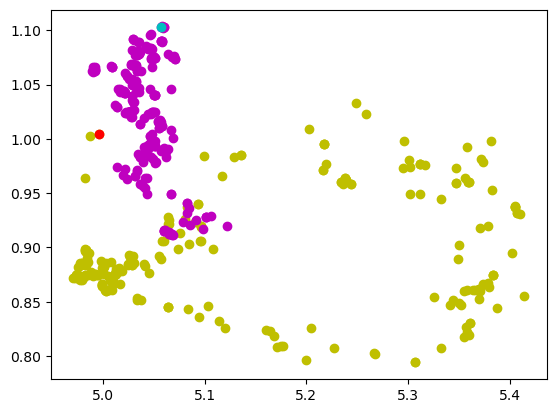

In [65]:
# calc.rと同じ設定　初期点を真の値に
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

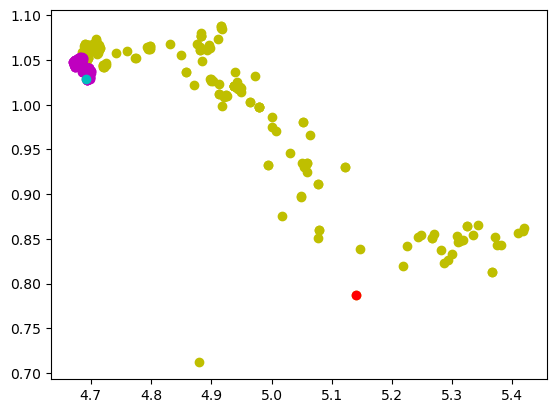

In [62]:
# calc.rと同じ設定　初期点をロバストに
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

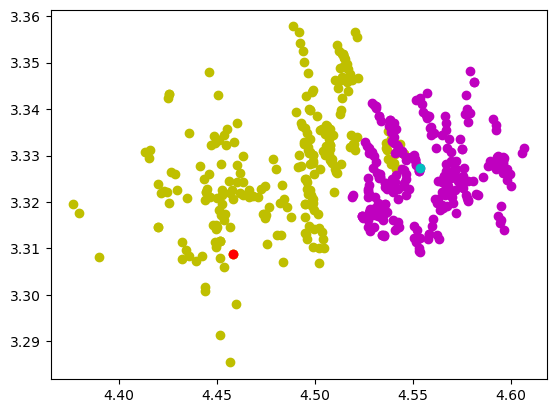

In [58]:
# calc.rと同じ設定(mgradのalpha_v -> np.sqrt(alpha_v))
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

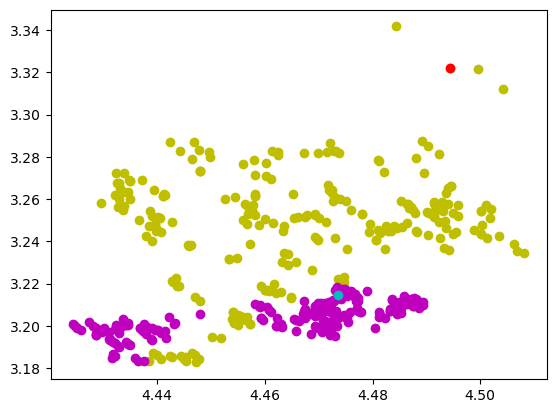

In [56]:
# calc.rと同じ設定
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

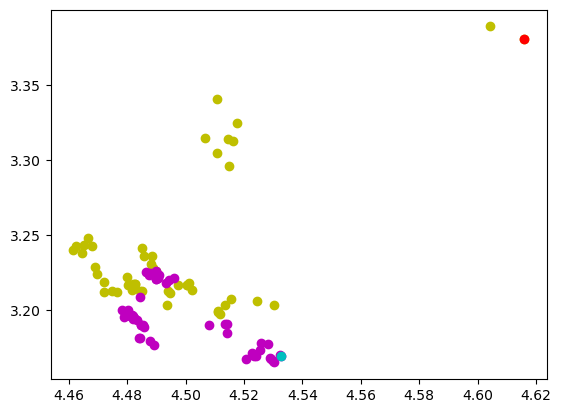

In [53]:
# par reg2にもdecayを行う
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

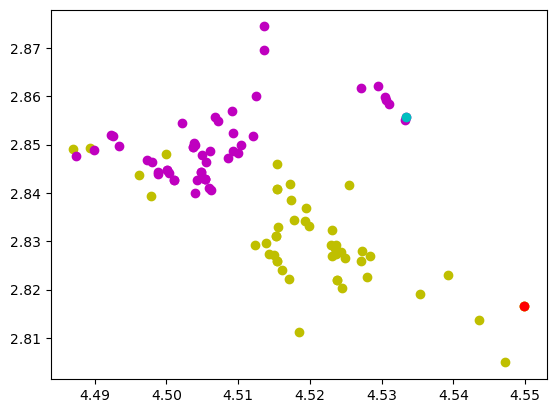

In [47]:
# mgradをもどした
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
# np.save("data/exper_iter100_exchange_mu_and_muout_par_reg12_is_0", npres)

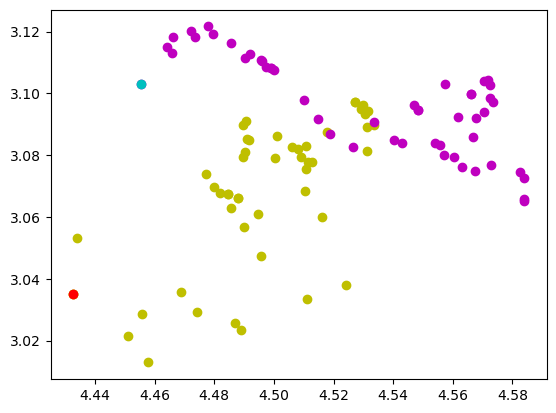

In [44]:
# mu = 5, mu_out = 0 par_reg1,2 = 0
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter100_exchange_mu_and_muout_par_reg12_is_0", npres)

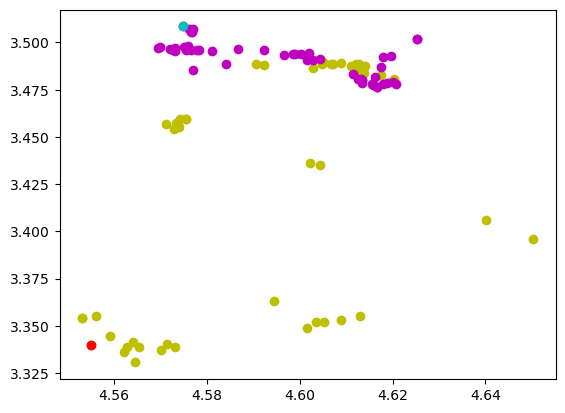

In [39]:
# mu = 5, mu_out = 0 par_reg2 = 0
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter100_exchange_mu_and_muout_par_reg2_is_0", npres)

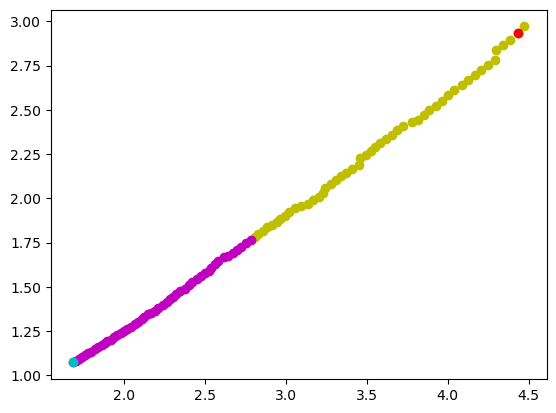

In [34]:
# mu = 5, mu_out = 0
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter100_exchange_mu_and_muout", npres)

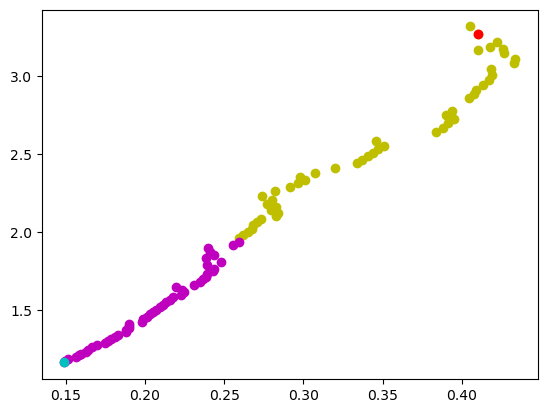

In [30]:
# sigma**2 of mu of mgrad change to sigma
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter100_change_mgrad", npres)
# (0,0)に近づいているだけ？？

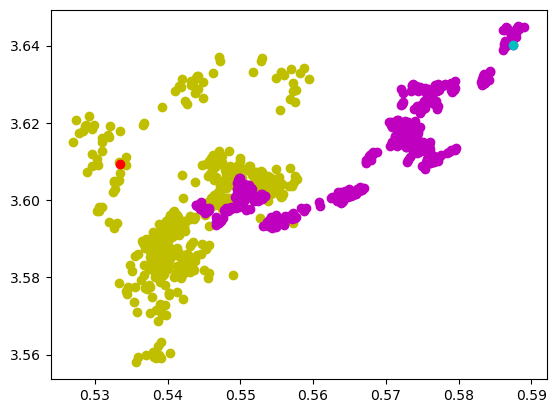

In [24]:
#reg2 = 0
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter1000_reg2_is_0", npres)

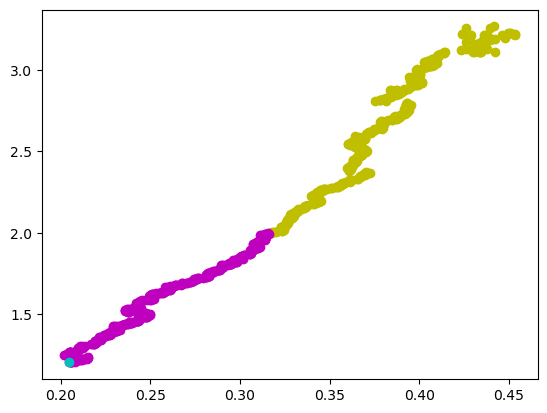

In [18]:
# L = 100
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")
np.save("data/exper_iter1000", npres)

In [19]:
x[-1], y[-1]

(0.20455972984160037, 1.2034883233876474)

In [13]:
np.save("data/exper_iter500", npres)

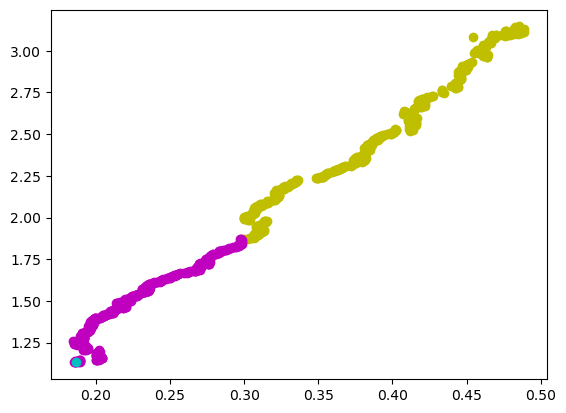

In [35]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

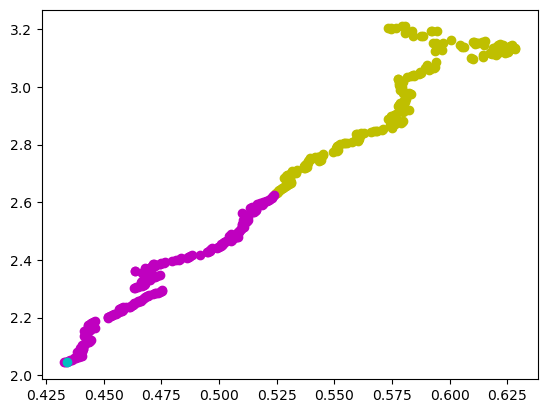

In [32]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

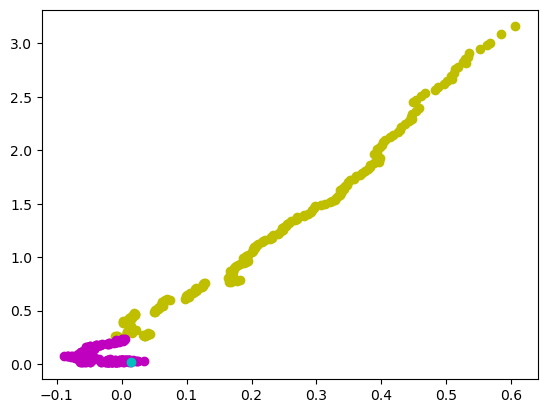

In [29]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

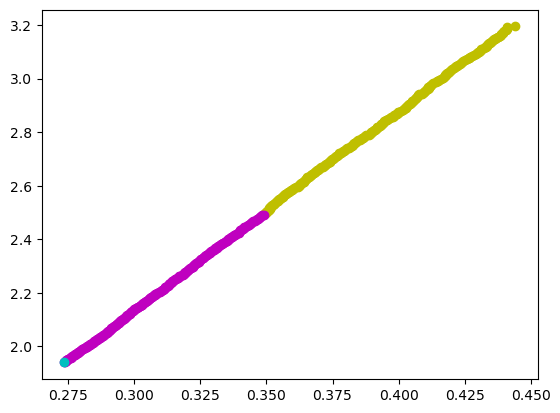

In [24]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

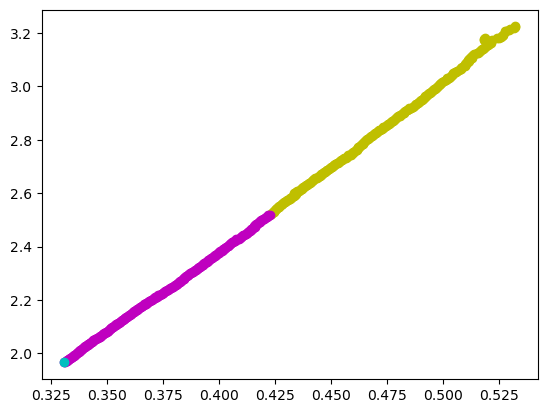

In [22]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

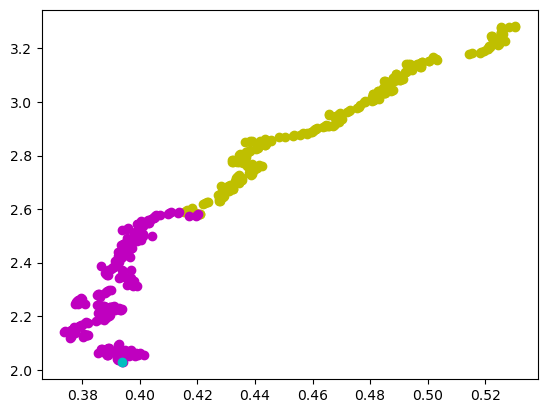

In [19]:
# L = 100 from 1
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

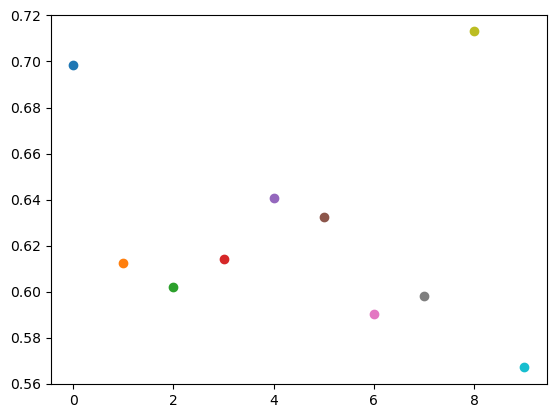

In [10]:
# change reg1 mu
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][0])

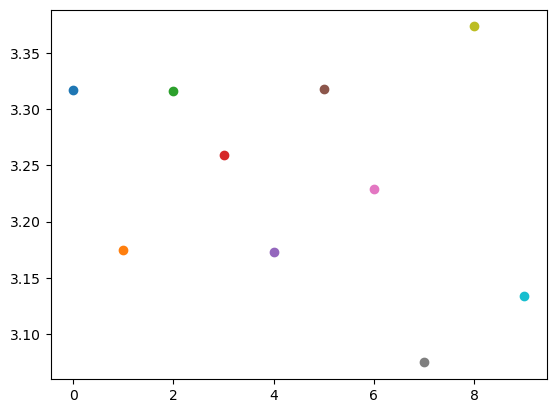

In [11]:
# change reg1 sd
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][1])

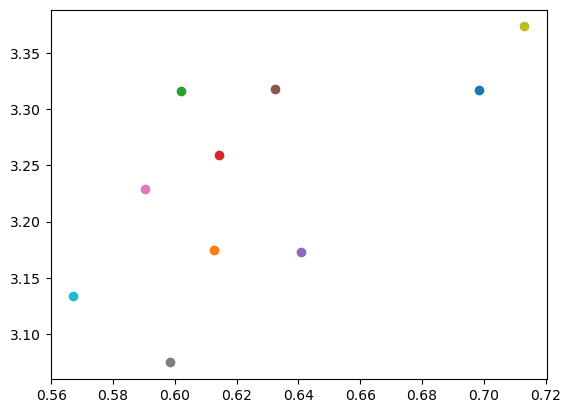

In [8]:
# change reg1 
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])

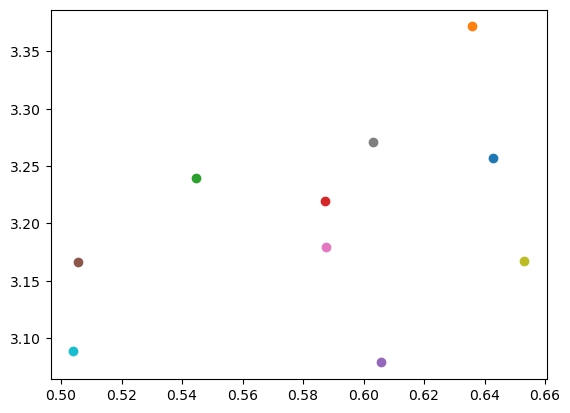

In [5]:
# fix GD removing discount
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])

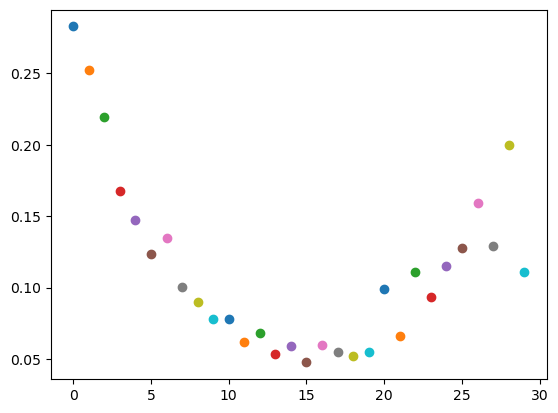

In [5]:
# change reg2
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][0])

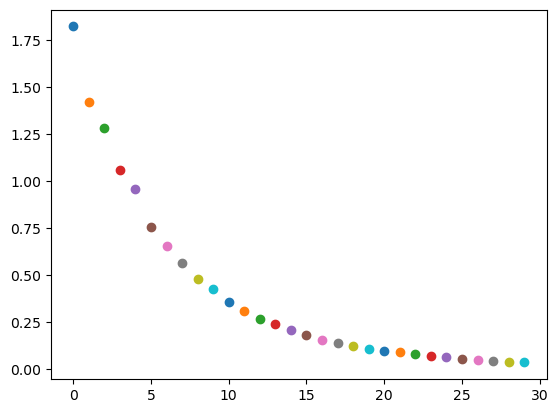

In [6]:
# change reg2
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][1])

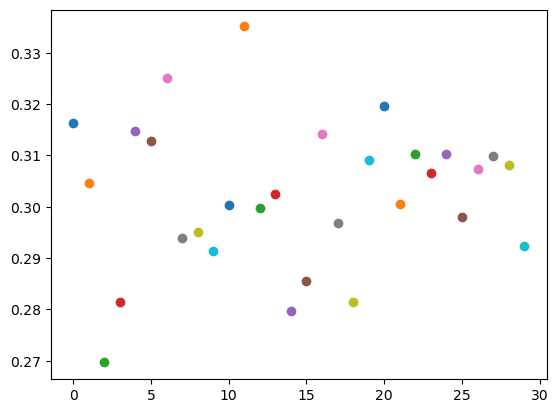

In [12]:
# change n 300 to 1300
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][0])

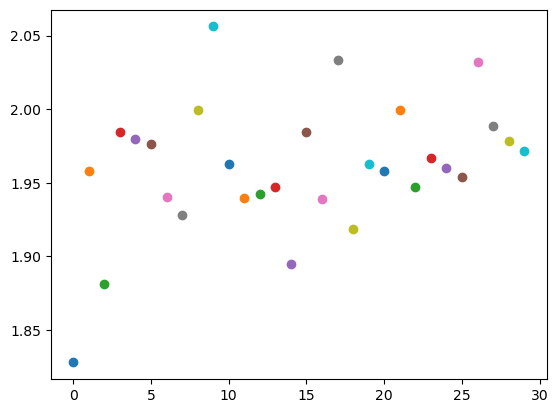

In [13]:
# change n 300 to 1300
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][1])

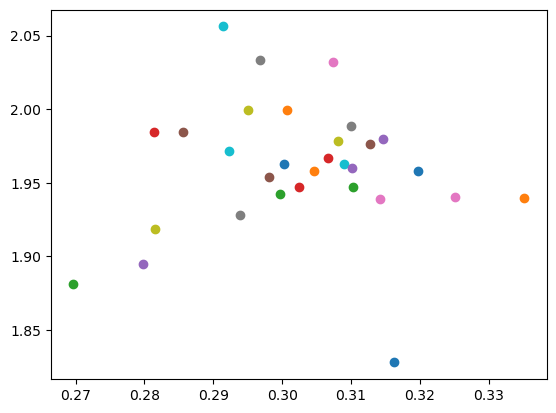

In [11]:
# change n 300 to 1300
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
# plt.savefig("experiment/2.png")

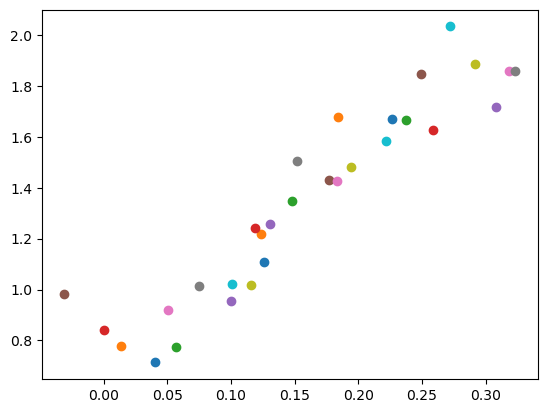

In [6]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
plt.savefig("experiment/2.png")

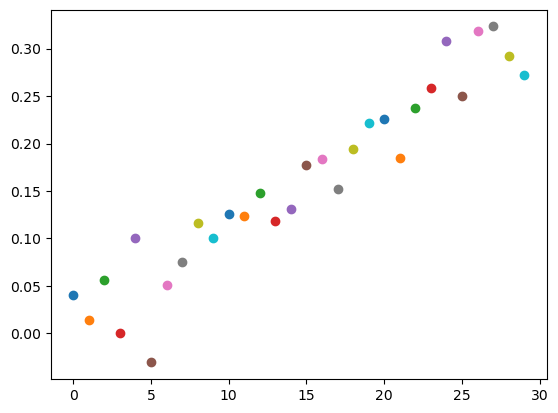

In [7]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][0])
plt.savefig("experiment/2.png")

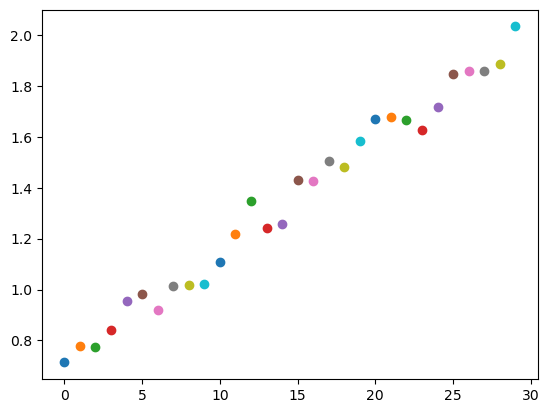

In [8]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(i, npres[i][-1][1])
plt.savefig("experiment/2.png")

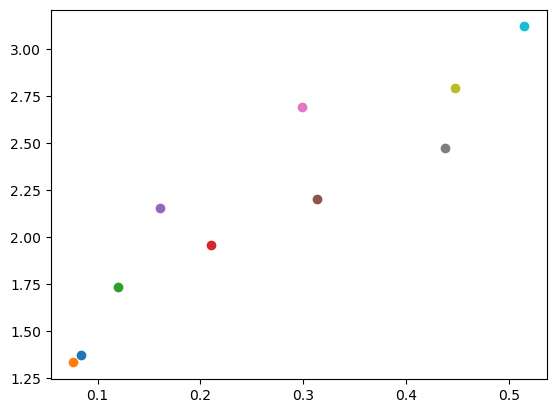

In [20]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
plt.savefig("experiment/fix_SGD_and_tune_lambda.png")

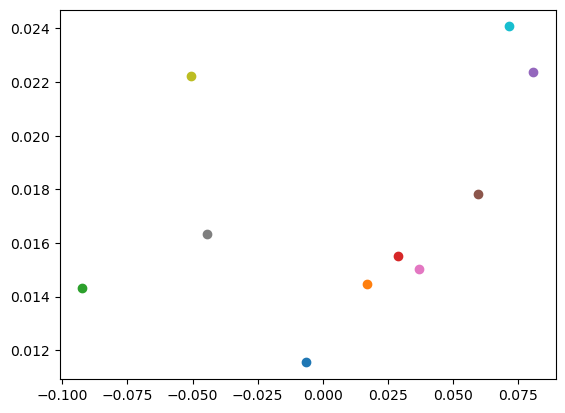

In [15]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
plt.savefig("experiment/fix_SGD.png")

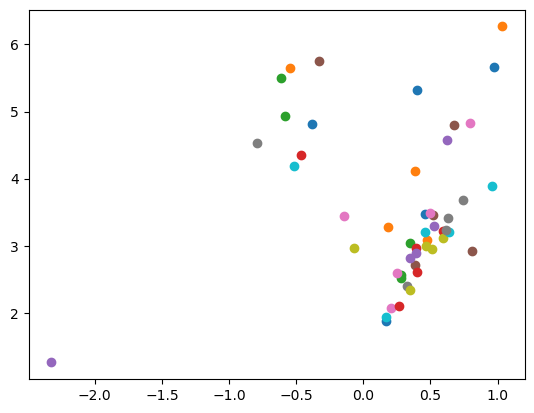

In [10]:
# change eps 0.01 to 0.1
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
plt.savefig("experiment/change_eps_001_to_01_50iter.png")

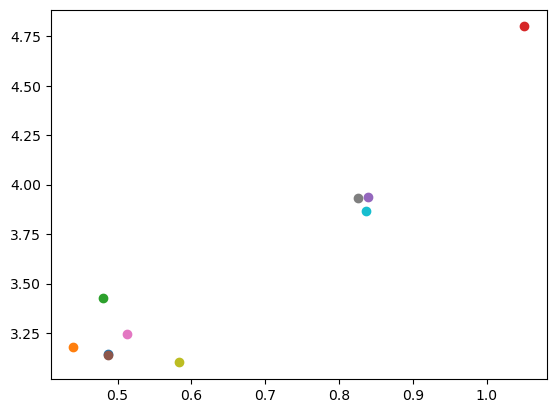

In [32]:
# n = 600
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])
plt.savefig("experiment/n=600.png")

In [10]:
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y)
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")

array([0.12473649, 0.81620839])

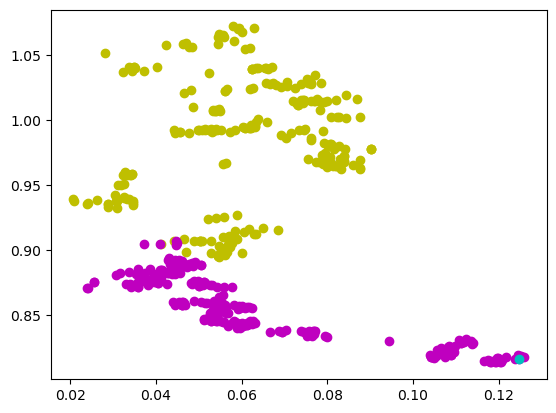

In [12]:
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]
plt.scatter(x,y, color = "y")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

# regなし

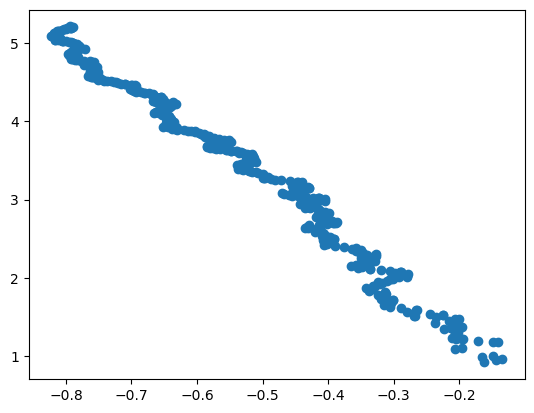

In [96]:
npres= np.array(res)[0]
x = npres[:, 0]; y=npres[:,1]
plt.scatter(x,y)

# regあり

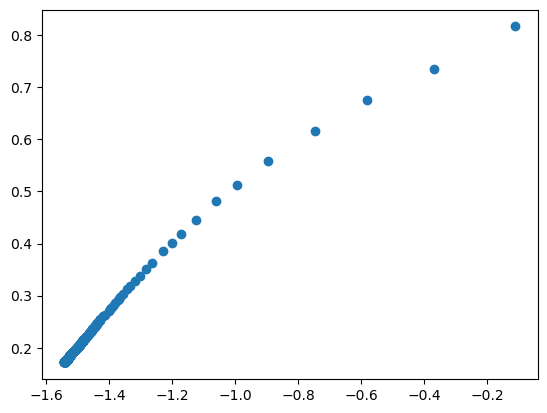

In [ ]:
res = np.array(res)[0]
x = res[:, 0]; y=res[:,1]
plt.scatter(x,y)

In [17]:
npres.shape

(10, 500, 2)

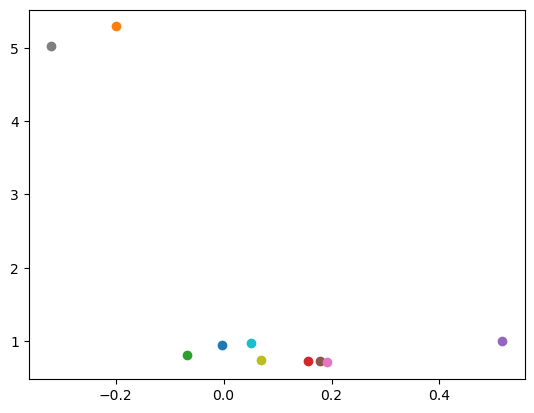

In [20]:
npres = np.array(res)
for i in range(npres.shape[0]):
    plt.scatter(npres[i][-1][0], npres[i][-1][1])